Create 2D mesh data member for crystal class: issue #10
https://github.com/radiasoft/rslaser/issues/10

Note: I did not create a params dict or any of that because I was unsure how this mesh would get "user values"

____________

1. Keep original crystal mesh, call it each time to make a temporary one, and then change the original with results of gain calculation
    a. if smaller than persistent mesh, need to augment with zeros so that we can do the algebra with them
    b. if larger than persistent mesh, grow to temporary and then shrink back to persistent
2. Change to just interpolation... if outside the range just give zeros

_________________
Imports

In [1]:
import sys, time
import math
import numpy as np
from pykern import pkcli
from pykern.pkcollections import PKDict

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rslaser.pulse import pulse
from rslaser.optics import crystal
from rslaser.optics import drift

import scipy.constants as const
from scipy.interpolate import RectBivariateSpline

import srwlib
from srwlib import srwl

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

______________
Set laser defaults

In [2]:
# specify parameters

_LASER_PULSE_DEFAULTS = PKDict(
        photon_e_ev=1.5498, # Photon energy [eV], calculated from 800nm wavelength
        pulseE=0.001,
        tau_fwhm=0.3e-13,
)

# Instantiate the default parameters
params = _LASER_PULSE_DEFAULTS.copy()

___________
Instantiate the laser pulse

In [3]:
thisPulse = pulse.LaserPulse(params)

______________
Define a simple lattice

Text(0.5, 1.0, 'Init Density Mesh')

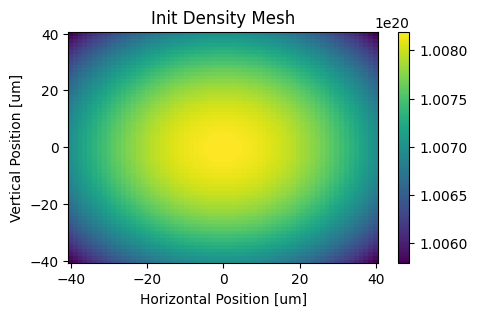

In [4]:
# instantiate a drift
L_drift = 0.50  # [m]
e_drift = drift.Drift(L_drift)

# instantiate the crystal
crystal_params = PKDict(length = 0.01,  # [m]
                        nslice = 1,
                        )
e_crystal = crystal.Crystal(crystal_params)

# define a simple lattice
lattice = [(e_drift,'default'), 
           (e_crystal,'n0n2_srw'), 
           (e_drift,'default')
          ]

slice = e_crystal.slice[0]

x = np.linspace(slice.pop_inversion_xstart,slice.pop_inversion_xfin,slice.pop_inversion_nx)
y = np.linspace(slice.pop_inversion_ystart,slice.pop_inversion_yfin,slice.pop_inversion_ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, slice.pop_inversion_mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Init Density Mesh')

______________
Propagate

In [5]:
# Propagate the pulse through the lattice
for iterator in lattice:
    current_elem, prop_type = iterator
    thisPulse = current_elem.propagate(thisPulse, prop_type)

prop_type = n0n2_srw
n0: 1.75, n2: 1.75
Propagated pulse slice  1  of  3
Propagated pulse slice  2  of  3
Propagated pulse slice  3  of  3


______________
Plot the CrystalSlice.sigma_mesh for the single slice

In [6]:
# slice = e_crystal.slice[0]

# x = np.linspace(thisPulse.slice[2].wfr.mesh.xStart,thisPulse.slice[2].wfr.mesh.xFin,thisPulse.slice[2].wfr.mesh.nx)
# y = np.linspace(thisPulse.slice[2].wfr.mesh.yStart,thisPulse.slice[2].wfr.mesh.yFin,thisPulse.slice[2].wfr.mesh.ny)
    
# # plot the excited state density
# fig = plt.figure(figsize=(5,3))
# ax = fig.gca()
# plt.pcolormesh(x*1e6, y*1e6, slice.temp_pop_inversion, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
# plt.colorbar()
# ax.set_ylabel(r'Vertical Position [um]')
# ax.set_xlabel(r'Horizontal Position [um]')
# ax.set_title('Excited State Density - After Propagation')

________________
For comparison, create ExcitedStates object containing 2d mesh of excited state density (sigma) for comparison #Old Method

In [7]:
class ExcitedStates():
    
    def __init__(self, params=None):
        self.nx = params.nx
        self.ny = params.ny
        self.xStart = params.xStart
        self.xFin = params.xFin
        self.yStart = params.yStart
        self.yFin = params.yFin
        
        x = np.linspace(self.xStart,self.xFin,self.nx)
        y = np.linspace(self.yStart,self.yFin,self.ny)
        xv, yv = np.meshgrid(x, y)
        self.mesh = np.exp(-(xv**2.0 + yv**2.0)/((self.xFin-self.xStart)/4.0)**2.0)

    # Scale the excited states mesh to match the pulse wavefront params
    # For increaing the mesh size: use values of zero
    def _scale(self, lp_wfr):       # Assumes wfr xFin, yFin > 0 and xStart, yStart < 0
        
        dx = (self.xFin - self.xStart)/self.nx
        dy = (self.yFin - self.yStart)/self.ny
        nx_init = self.nx
        ny_init = self.ny
        
        d_xFin = (lp_wfr.mesh.xFin - self.xFin)
        d_yFin = (lp_wfr.mesh.yFin - self.yFin)
        
        if d_xFin > 0:         # Add rows to the end of the mesh
            self.nx += math.ceil(d_xFin/dx)
            self.xFin += math.ceil(d_xFin/dx)*dx
            self.mesh = np.append(self.mesh, np.zeros((math.ceil(d_xFin/dx),np.shape(self.mesh)[1])), axis=0)
        #elif d_xFin < 0:       # Remove rows from the end of the mesh
        #    self.mesh = np.delete(self.mesh, np.s_[self.nx:nx_init], axis=0)    
            
        if d_yFin > 0:         # Add columns to the end of the mesh
            self.ny += math.ceil(d_yFin/dy)
            self.yFin += math.ceil(d_yFin/dy)*dy
            self.mesh = np.append(self.mesh, np.zeros((np.shape(self.mesh)[0],math.ceil(d_yFin/dy))), axis=1)
        #elif d_yFin < 0:       # Delete columns from the end of the mesh
        #    self.mesh = np.delete(self.mesh, np.s_[self.ny:ny_init], axis=1)
                
        d_xStart = (self.xStart - lp_wfr.mesh.xStart)
        d_yStart = (self.yStart - lp_wfr.mesh.yStart)
                     
        if d_xStart > 0:       # Add rows to the start of the mesh
            self.nx += math.ceil(d_xStart/dx)
            self.xStart -= math.ceil(d_xStart/dx)*dx
            self.mesh = np.append(np.zeros((math.ceil(d_xStart/dx),np.shape(self.mesh)[1])), self.mesh, axis=0)
        #elif d_xStart < 0:     # Delete rows from the start of the mesh
        #    self.mesh = np.delete(self.mesh, np.s_[0:-math.ceil(d_xStart/dx)], axis=0)
            
        if d_yStart > 0:       # Add columns to the start of the mesh
            self.ny += math.ceil(d_yStart/dy)
            self.yStart -= math.ceil(d_yStart/dy)*dy
            self.mesh = np.append(np.zeros((np.shape(self.mesh)[0],math.ceil(d_yStart/dy))), self.mesh, axis=1)
        #elif d_yStart < 0:     # Delete columns from the start of the mesh
        #    self.mesh = np.delete(self.mesh,  np.s_[0:-math.ceil(d_yStart/dy)], axis=1)

    # Interpolate the excited states mesh to match the pulse wavefront params
    def interpolate(self, lp_wfr):
        
        self._scale(lp_wfr)
            
        # check if n cells matches
        
        excited_states_x = np.linspace(self.xStart,self.xFin,self.nx)
        excited_states_y = np.linspace(self.yStart,self.yFin,self.ny)
        
        lp_wfr_x = np.linspace(lp_wfr.mesh.xStart,lp_wfr.mesh.xFin,lp_wfr.mesh.nx)
        lp_wfr_y = np.linspace(lp_wfr.mesh.yStart,lp_wfr.mesh.yFin,lp_wfr.mesh.ny)
            
        # Interpolate the excited states mesh to match the pulse wavefront params
        if not (np.array_equal(excited_states_x, lp_wfr_x) and np.array_equal(excited_states_y, lp_wfr_y)):
            rect_biv_spline = RectBivariateSpline(excited_states_x, excited_states_y, self.mesh)

            self.mesh = rect_biv_spline(lp_wfr_x, lp_wfr_y) #Evaluate the spline at points
            self.xStart = lp_wfr.mesh.xStart
            self.xFin = lp_wfr.mesh.xFin
            self.yStart = lp_wfr.mesh.yStart
            self.yFin = lp_wfr.mesh.yFin
            self.nx = np.shape(self.mesh)[0]
            self.ny = np.shape(self.mesh)[1]
            

_____________
Interpolating to a smaller grid: plot the mesh values before and after

Text(0.5, 1.0, 'Excited State Density - After Interpolation')

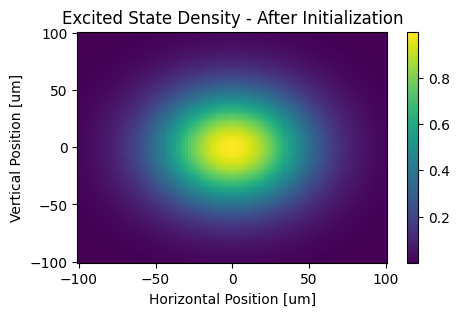

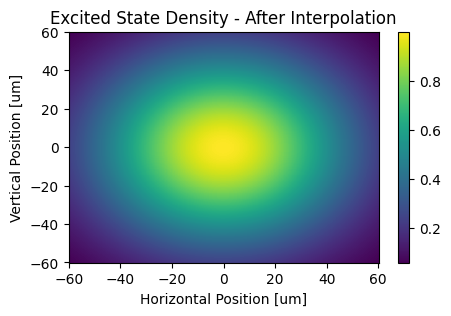

In [8]:
_EXCITED_STATES_DEFAULTS = PKDict(
        nx = 100,
        ny = 100,
        xStart = -10.0e-5, #10.0e-5
        xFin = 10.0e-5,
        yStart = -10.0e-5,
        yFin = 10.0e-5,    
)

# Instantiate the default parameters:
params = _EXCITED_STATES_DEFAULTS.copy()

thisSigma = ExcitedStates(params)
thisPulse_wfr = thisPulse.slice[0].wfr

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Initialization')

thisSigma.interpolate(thisPulse_wfr)

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Interpolation')


_____________
Interpolating to a larger grid: plot the mesh values before and after

Text(0.5, 1.0, 'Excited State Density - After Interpolation')

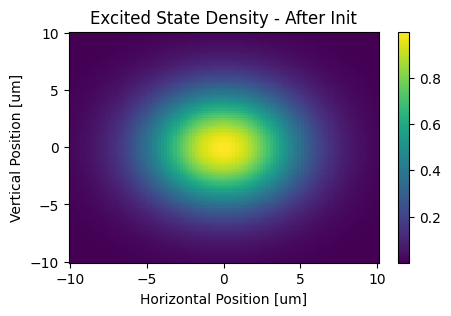

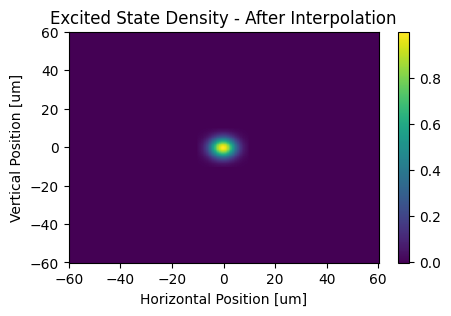

In [9]:
_EXCITED_STATES_DEFAULTS = PKDict(
        nx = 100,
        ny = 100,
        xStart = -1.0e-5, #10.0e-5
        xFin = 1.0e-5,
        yStart = -1.0e-5,
        yFin = 1.0e-5,    
)

# Instantiate the default parameters:
params = _EXCITED_STATES_DEFAULTS.copy()

thisSigma = ExcitedStates(params)
thisPulse_wfr = thisPulse.slice[0].wfr

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Init')

thisSigma.interpolate(thisPulse_wfr)

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Interpolation')


In [10]:
# print('\nwfr nx: ', thisPulse_wfr.mesh.nx)
# print('wfr ny: ', thisPulse_wfr.mesh.ny)
# print('wfr xStart: ', thisPulse_wfr.mesh.xStart)
# print('wfr xFin: ', thisPulse_wfr.mesh.xFin)
# print('wfr yStart: ', thisPulse_wfr.mesh.yStart)
# print('wfr yFin: ', thisPulse_wfr.mesh.yFin)

# print('\nSigma nx: ', thisSigma.nx)
# print('Sigma ny: ', thisSigma.ny)
# print('Sigma xStart: ', thisSigma.xStart)
# print('Sigma xFin: ', thisSigma.xFin)
# print('Sigma yStart: ', thisSigma.yStart)
# print('Sigma yFin: ', thisSigma.yFin)
# print('Sigma mesh shape: ', np.shape(thisSigma.mesh))

____________
An example of if we interpolate before scaling...

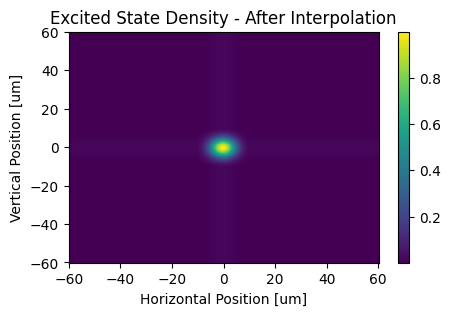

What do we get for values outside the interpolation map?

In [11]:
# original_array = np.ones((50,50))
# x = np.linspace(-1,1,50)
# y = np.linspace(-1,1,50)

# rbs_test = RectBivariateSpline(x, y, original_array)

# test_array = rbs_test(x_test, y_test)

x = np.array([1,2,3,4])
y = np.array([1,2,3,4,5])
vals = np.array([
    [4,1,4,4,2],
    [4,2,3,2,6],
    [3,7,4,3,5],
    [2,4,5,3,4]
])

rect_B_spline = RectBivariateSpline(x, y, vals)

a = np.array([-1.0, 100.0, -1.0, 2.5, -0.001])
b = np.array([-1.0, 100.0, 7.0, 100.0, 0.0])

#print(rect_B_spline.ev(a,b))

# What if we wrap it in zeros?
    # Smaller: no big deal right? not looking at the edge
    # Larger: only one row of zeros all the way around... (mesh might already be zero at edge, but can't count on that)
    
x2 = np.array([0,1,2,3,4,5])
y2 = np.array([0,1,2,3,4,5,6])
vals2 = np.array([
    [0,0,0,0,0,0,0],
    [0,4,1,4,4,2,0],
    [0,4,2,3,2,6,0],
    [0,3,7,4,3,5,0],
    [0,2,4,5,3,4,0],
    [0,0,0,0,0,0,0]
])

rect_B_spline2 = RectBivariateSpline(x2, y2, vals2)

rect_B_spline2.ev(a,b)

# Do this for now, with comment for why and where it might fail

array([8.13676313e-18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.13676313e-18])

In [12]:
class ExcitedStates():
    
    def __init__(self, params=None):
        self.nx = params.nx
        self.ny = params.ny
        self.xStart = params.xStart
        self.xFin = params.xFin
        self.yStart = params.yStart
        self.yFin = params.yFin
        
        #x = np.linspace(self.xStart,self.xFin,self.nx)
        #y = np.linspace(self.yStart,self.yFin,self.ny)
        #xv, yv = np.meshgrid(x, y)
        self.mesh = np.ones((self.nx,self.ny)) #np.exp(-(xv**2.0 + yv**2.0)/((self.xFin-self.xStart)/4.0)**2.0)

def interpolate_pop_inversion(crystalSlice, lp_wfr):
    # Function returns a temporary mesh that is a copy of the original interpolated to match the wfr mesh 
    # (with possible zero-padding, if needed) for calling in the gain calculation
    
    pop_inversion_x = np.linspace(crystalSlice.xStart,crystalSlice.xFin,crystalSlice.nx)
    pop_inversion_y = np.linspace(crystalSlice.yStart,crystalSlice.yFin,crystalSlice.ny)
    dx = (crystalSlice.xFin - crystalSlice.xStart)/crystalSlice.nx
    dy = (crystalSlice.yFin - crystalSlice.yStart)/crystalSlice.ny
    
    lp_wfr_x = np.linspace(lp_wfr.mesh.xStart,lp_wfr.mesh.xFin,lp_wfr.mesh.nx)
    lp_wfr_y = np.linspace(lp_wfr.mesh.yStart,lp_wfr.mesh.yFin,lp_wfr.mesh.ny)
       
    # Interpolate the excited states mesh to match the pulse wavefront params
    if not (np.array_equal(pop_inversion_x, lp_wfr_x) and np.array_equal(pop_inversion_y, lp_wfr_y)):
        
        # Add a wrapping of zeros
        crystalSlice.nx += 2
        crystalSlice.ny += 2
        
        crystalSlice.xFin += dx
        crystalSlice.yFin += dy
        crystalSlice.xStart -= dx
        crystalSlice.yStart -= dy
        
        # Add row to the end of the mesh
        crystalSlice.mesh = np.append(crystalSlice.mesh, np.zeros((1,np.shape(crystalSlice.mesh)[1])), axis=0)
        # Add column to the end of the mesh
        crystalSlice.mesh = np.append(crystalSlice.mesh, np.zeros((np.shape(crystalSlice.mesh)[0],1)), axis=1)
        # Add row to the start of the mesh
        crystalSlice.mesh = np.append(np.zeros((1,np.shape(crystalSlice.mesh)[1])), crystalSlice.mesh, axis=0)
        # Add column to the start of the mesh
        crystalSlice.mesh = np.append(np.zeros((np.shape(crystalSlice.mesh)[0],1)), crystalSlice.mesh, axis=1)     
        
        pop_inversion_x = np.linspace(crystalSlice.xStart,crystalSlice.xFin,crystalSlice.nx)
        pop_inversion_y = np.linspace(crystalSlice.yStart,crystalSlice.yFin,crystalSlice.ny)
        
        # Create the spline for interpolation
        rect_biv_spline = RectBivariateSpline(pop_inversion_x, pop_inversion_y, crystalSlice.mesh)
        
        # Evaluate the spline at wavefront gridpoints (has same nx,ny,xstart,xfin,ystart,yfin as wfr.mesh)        
        return rect_biv_spline(lp_wfr_x, lp_wfr_y)  

0.9999999999994621
0.9999999999994628
0.9999999999994625
0.9999999999994622


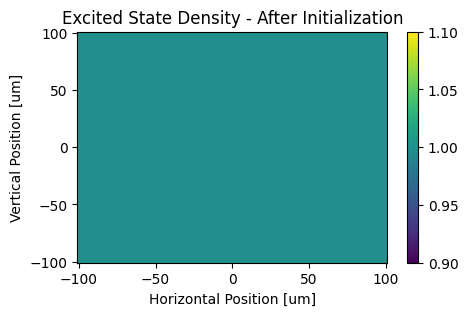

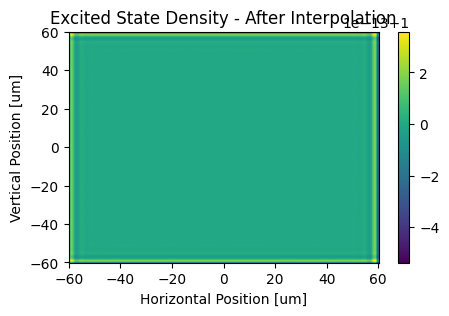

In [13]:
_EXCITED_STATES_DEFAULTS = PKDict(
        nx = 100,
        ny = 100,
        xStart = -10.0e-5, #10.0e-5
        xFin = 10.0e-5,
        yStart = -10.0e-5,
        yFin = 10.0e-5,    
)

# Instantiate the default parameters:
params = _EXCITED_STATES_DEFAULTS.copy()

thisSigma = ExcitedStates(params)
thisPulse_wfr = thisPulse.slice[0].wfr

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Initialization')

temp_mesh = interpolate_pop_inversion(thisSigma, thisPulse_wfr)

x = np.linspace(thisPulse_wfr.mesh.xStart,thisPulse_wfr.mesh.xFin,thisPulse_wfr.mesh.nx)
y = np.linspace(thisPulse_wfr.mesh.yStart,thisPulse_wfr.mesh.yFin,thisPulse_wfr.mesh.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, temp_mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Interpolation')

print(temp_mesh[0,0])
print(temp_mesh[-1,-1])
print(temp_mesh[0,-1])
print(temp_mesh[-1,0])

-1.403249246093734e-18
0.0
0.0
0.0


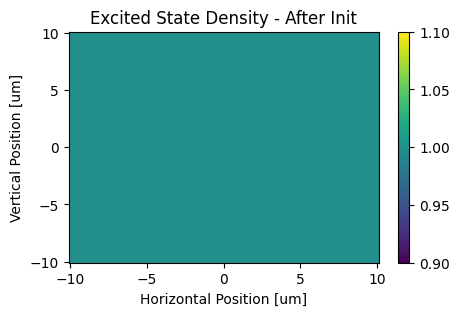

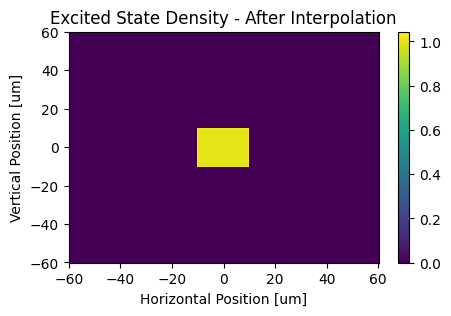

In [14]:
_EXCITED_STATES_DEFAULTS = PKDict(
        nx = 100,
        ny = 100,
        xStart = -1.0e-5, #10.0e-5
        xFin = 1.0e-5,
        yStart = -1.0e-5,
        yFin = 1.0e-5,    
)

# Instantiate the default parameters:
params = _EXCITED_STATES_DEFAULTS.copy()

thisSigma = ExcitedStates(params)
thisPulse_wfr = thisPulse.slice[0].wfr

x = np.linspace(thisSigma.xStart,thisSigma.xFin,thisSigma.nx)
y = np.linspace(thisSigma.yStart,thisSigma.yFin,thisSigma.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, thisSigma.mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Init')

temp_mesh = interpolate_pop_inversion(thisSigma, thisPulse_wfr)

x = np.linspace(thisPulse_wfr.mesh.xStart,thisPulse_wfr.mesh.xFin,thisPulse_wfr.mesh.nx)
y = np.linspace(thisPulse_wfr.mesh.yStart,thisPulse_wfr.mesh.yFin,thisPulse_wfr.mesh.ny)
    
# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(x*1e6, y*1e6, temp_mesh, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Excited State Density - After Interpolation')

print(temp_mesh[0,0])
print(temp_mesh[-1,-1])
print(temp_mesh[0,-1])
print(temp_mesh[-1,0])

In [15]:
print(temp_mesh[150,150])

-1.403249246093734e-18
